# Inference Time Baby 😎

In [184]:
import random
from pathlib import Path
from types import SimpleNamespace

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray_r'

import wandb

In [185]:
dataset_at = 'capecape/gtc/np_dataset:v1'
model_at = 'capecape/ddpm_clouds/zdggd0q5_ddpm_clouds:v0'

## Grab the Dataset

In [186]:
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact(dataset_at, type='dataset')
    dataset_dir = Path(artifact.download())

wandb: Downloading large artifact np_dataset:v1, 7633.24MB. 60 files... 
wandb:   60 of 60 files downloaded.  
Done. 0:0:0.0


## Grab the trained Model

In [187]:
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact(model_at, type='model')
    model_dir = Path(artifact.download())

wandb: Downloading large artifact zdggd0q5_ddpm_clouds:v0, 60.78MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


## everything together

In [188]:
config = SimpleNamespace(    
    epochs = 100,
    model_name="ddpm_clouds",
    noise_steps=1000,
    seed = 42,
    batch_size = 64,
    img_size = 128,
    device = "cuda",
    use_wandb = True,
    num_workers=8,
    num_frames=3,
    lr = 5e-4)

In [189]:
import torch
from fastprogress import progress_bar
from diffusers import UNet2DModel

from clouds import CloudDataset, ls

from torch_moving_mnist.utils import *

In [190]:
files = ls(Path(dataset_dir))
valid_ds = CloudDataset(files[-3:], valid=True, size=config.img_size)

In [191]:
model = UNet2DModel(in_channels=4, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)

load checkpoint

In [192]:
model.load_state_dict(torch.load(list(model_dir.glob("*.pth"))[0]))

<All keys matched successfully>

In [193]:
model = model.to(config.device)

## Sampling

In [194]:
def describe(img):
    print(  f"Image of type: {type(img)}\n"
            f"data type:     {img.dtype}\n"
            f"shape:         {img.shape}\n"
            f"min:           {img.min()}\n"
            f"max:           {img.max()}\n")

In [195]:
betamin,betamax,n_steps = 0.0001,0.02,config.noise_steps
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

@torch.no_grad()
def ddpm_sample(model, xt):
    "Slightly different than the one used during training, takes only a lenght 3 tensor)"
    device = next(model.parameters()).device
    past_frames = xt
    new_frame = torch.randn_like(xt[:,-1:], dtype=xt.dtype, device=device)
    preds = []
    for t in progress_bar(reversed(range(n_steps)), total=n_steps, leave=False):
        t_batch = torch.full((new_frame.shape[0],), t, device=device, dtype=torch.long)
        z = torch.randn(new_frame.shape, device=device) if t > 0 else torch.zeros(new_frame.shape, device=device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model(torch.cat([past_frames, new_frame], dim=1), t_batch).sample
        x_0_hat = ((new_frame - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        new_frame = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + new_frame * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(new_frame.float().cpu())
    return preds

### Using diffusers stuff

In [196]:
from diffusers.schedulers import DDPMScheduler, DDIMScheduler

In [197]:
@torch.no_grad()
def diff_sample(model, past_frames, sched, **kwargs):
    "Suing Diffusers built in samplers"
    device = next(model.parameters()).device
    new_frame = torch.randn_like(past_frames[:,-1:], dtype=past_frames.dtype, device=device)
    preds = []
    for t in progress_bar(sched.timesteps, leave=False):
        noise = model(torch.cat([past_frames, new_frame], dim=1), t).sample
        new_frame = sched.step(noise, t, new_frame, **kwargs).prev_sample
        preds.append(new_frame.float().cpu())
    return preds

In [207]:
from functools import partial

def ddim_sampler(steps=350, eta=1.):
    ddim_sched = DDIMScheduler()
    ddim_sched.set_timesteps(steps)
    return partial(diff_sample, sched=ddim_sched, eta=eta)

## Inference

In [199]:
len(valid_ds)

278

torch.Size([1, 4, 128, 128])


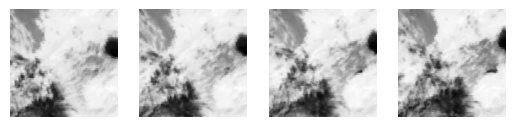

In [200]:
idx = 220

x0 = valid_ds[idx:idx+1].to(config.device)
print(x0.shape)
show_images(x0.squeeze())

In [201]:
describe(x0)

Image of type: <class 'torch.Tensor'>
data type:     torch.float32
shape:         torch.Size([1, 4, 128, 128])
min:           -0.4264844059944153
max:           0.3712269067764282



DDPM

In [203]:
preds = ddpm_sample(model, x0[:,:-1,...])
last_frame_ddpm = preds[-1].squeeze()

Diffusers' DDPM

In [204]:
preds = diff_sample(model, x0[:,:-1,...], DDPMScheduler())
last_frame_diff_ddpm = preds[-1].squeeze()

Diffusers' DDIM

In [208]:
ddim_sample = ddim_sampler(350)
preds = ddim_sample(model, x0[:,:-1,...])
last_frame_diff_ddim = preds[-1].squeeze()

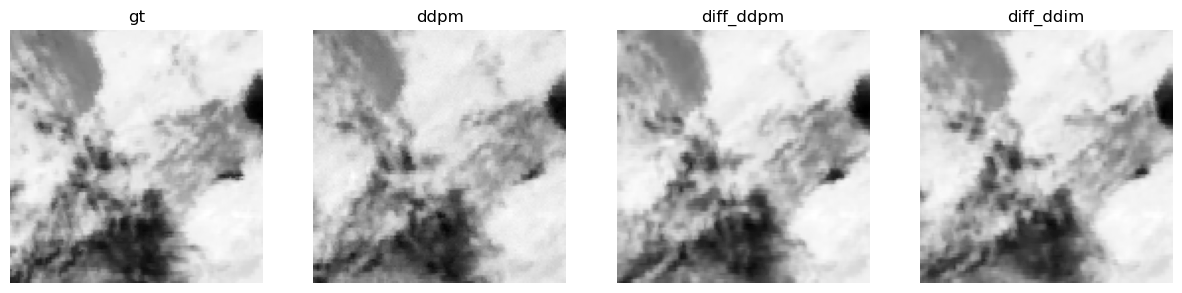

In [209]:
images = [x0[:,-1,...].squeeze(), last_frame_ddpm, last_frame_diff_ddpm, last_frame_diff_ddim]
titles = ["gt", "ddpm", "diff_ddpm", "diff_ddim"]
show_images(images, titles=titles, figsize=(15,5))

In [210]:
def htile(img):
    return torch.cat(img.split(1), dim=-1)

In [211]:
def vtile(img):
    return torch.cat(img.split(1), dim=-2)

In [212]:
def vhtile(*imgs):
    return vtile(torch.cat([htile(img) for img in imgs], dim=0))

## Sampler more timesteps

In [213]:
N = 2

In [214]:
def sample_more(frames, n=1, sampler=ddpm_sample):
    "Autoregressive sampling"
    for _ in progress_bar(range(n), total=n):
        new_frame = sampler(model, frames[:,-3:,...])[-1]
        frames = torch.cat([frames, new_frame.to(frames.device)], dim=1)
    return frames.cpu()

In [215]:
frames = sample_more(x0, n=N, sampler=ddim_sampler())

Samples

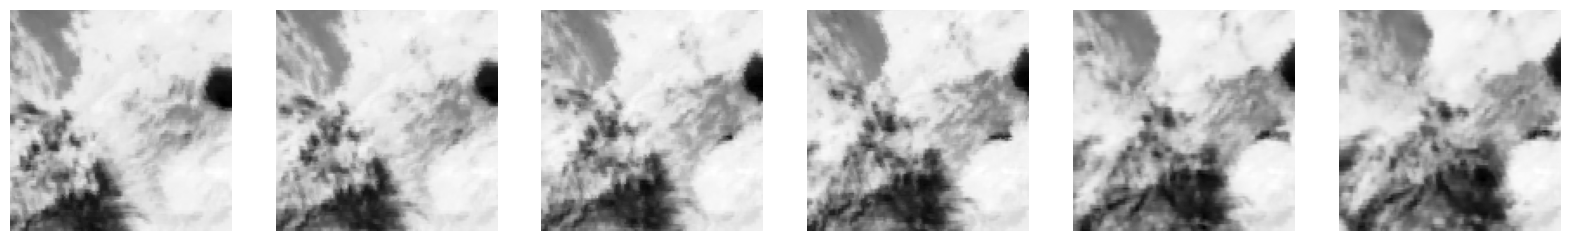

In [216]:
show_images(frames.squeeze(), figsize=(20,10))

GT

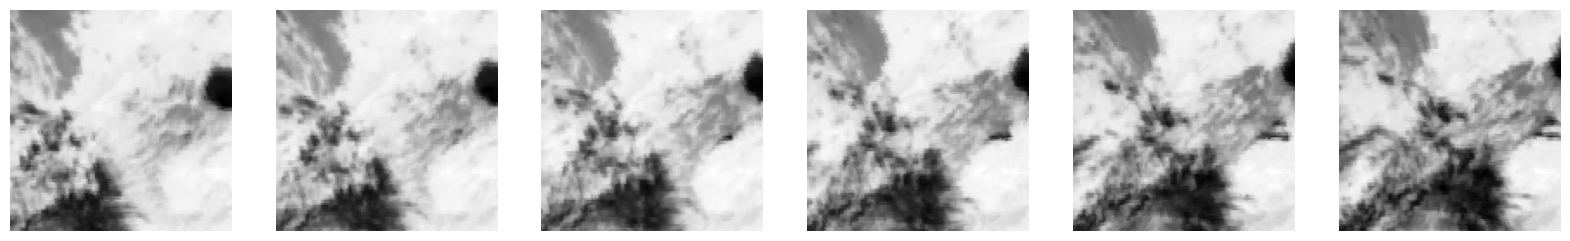

In [217]:
show_images(valid_ds[idx:idx+4+N,0,...], figsize=(20,10))

In [218]:
import numpy as np

def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

def preprocess_frames(data):
    sdata = scale(data.squeeze())
    # print(sdata.shape)
    def tfm(frame):
        rframe = 255 * frame
        return rframe.cpu().numpy().astype(np.uint8)
    return [tfm(frame) for frame in sdata]

def to_video(data):
    "create wandb.Video container"
    frames = preprocess_frames(data)
    vid = np.stack(frames)[:, None, ...]
    return wandb.Video(vid)

## Different Noises produce different outputs:
If we generate the same sequence multiple times, we will get different diffusions, let's check that

In [219]:
config = SimpleNamespace(
    N = 10,  # number of future frames
    bs = 16, # how many samples
    num_random_experiments = 3, # we will perform inference multiple times on the same inputs
    seed=42,
    device="cuda:0",
    sampler="ddim",
    sampler_steps=350,
)

random.seed(config.seed)

select 8 sequences

In [220]:
idxs = random.choices(range(len(valid_ds) - config.N), k=config.bs)  # select some samples
x0 = valid_ds[idxs].to(config.device)

In [222]:
if config.sampler == "ddim":
    sampler = ddim_sampler(config.sampler_steps)
else:
    sampler = ddpm_sample

In [ ]:
sequences = []
for _ in range(config.num_random_experiments):
    frames = sample_more(x0, config.N, sampler=sampler)
    sequences.append(frames)

In [ ]:
table = wandb.Table(columns=["id", "gt", *[f"gen_{i}" for i in range(config.num_random_experiments)], "gt/gen"])

In [ ]:
for i, idx in enumerate(idxs):
    gt_vid = to_video(valid_ds[idx:idx+4+config.N,0,...])
    pred_vids = [to_video(frames[i]) for frames in sequences]
    gt_gen = wandb.Image(vhtile(valid_ds[idx:idx+4+config.N,0,...], *[frames[i] for frames in sequences]))
    table.add_data(idx, gt_vid, *pred_vids, gt_gen)

In [ ]:
with wandb.init(project="ddpm_clouds", config=config):
    wandb.log({f"gen_table_{config.N}_random":table})

In [ ]:
!sudo poweroff